# Building Segmentation Model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../src'))
sys.path.append(os.path.join(os.getcwd(), '../src/utilities'))
from src import CROPS_PATH, MODELS_PATH
from scoring import scoring_segmentation as scoring

In [2]:
path = Path(CROPS_PATH)
path_lbl = path/'labels'
path_img = path/'images'
path_mask = path/'masks'

## Load Data 

In [3]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True, convert_mode='RGB') for 3 channel target masks

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=False, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [4]:
# the classes corresponding to each channel
codes = np.array(['no-building','building'])
codes = np.array(['R','G','B'])

#get label from function
get_y_fn = lambda x: path_mask/f'{x.stem + x.suffix}'

#image size and batch size
size = 256
bs = 40

# define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)

In [5]:
data = (SegItemListCustom.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

# View data

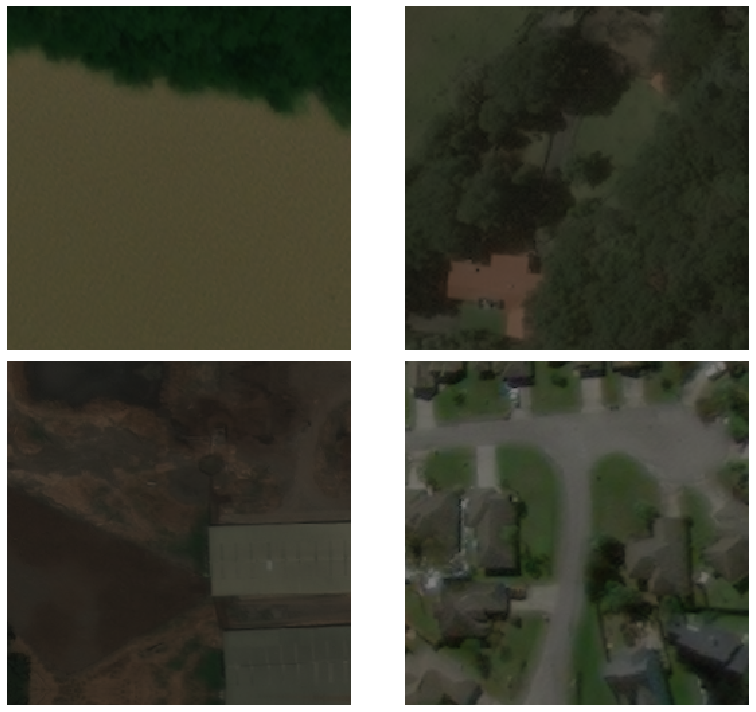

In [6]:
data.show_batch(rows=2, figsize=(12,10), ds_type=DatasetType.Train)

## Loss and Matrics

In [7]:
def dice_loss(input_, target):
    smooth = 1.
    input_ = torch.sigmoid(input_)
    iflat = input_.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.count = 0

    def forward(self, inputs, targets):
        eps = 1e-8
        inputs = torch.clamp(inputs, eps, 1. - eps)
        targets = torch.clamp(targets, eps, 1. - eps)
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-1 * bce_loss)
        f_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return f_loss.mean()
        elif self.reduction == 'sum':
            return f_loss.sum()
        else:
            return f_loss


class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction

    def forward(self, input_, target):
        loss = dice_loss(input_, target)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(), DiceLoss()], loss_wts=[1, 1], ch_wts=[1, 1, 1]):
        super().__init__()
        self.reduction = reduction
        self.loss_funcs = loss_funcs
        self.loss_wts = loss_wts
        self.ch_wts = ch_wts

    def forward(self, output, target):
        for loss_func in self.loss_funcs:
            loss_func.reduction = self.reduction
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt, c in zip(self.ch_wts, range(channels)):
            ch_loss = 0
            for loss_wt, loss_func in zip(self.loss_wts, self.loss_funcs):
                ch_loss += loss_wt * loss_func(output[:, c, None], target[:, c, None])
            loss += ch_wt * ch_loss
        loss = loss / sum(self.ch_wts)
        return loss


def acc_thresh_multich(input_: Tensor, target: Tensor, thresh: float = 0.5, sigmoid: bool = True,
                       one_ch: int = None) -> Rank0Tensor:
    """
    Compute accuracy when `y_pred` and `y_true` are the same size. C
    calculate metrics on one channel or on all 3 channels
    """
    
    if sigmoid:
        input_ = input_.sigmoid()
    n = input_.shape[0]

    if one_ch is not None:
        input_ = input_[:, one_ch, None]
        target = target[:, one_ch, None]

    input_ = input_.view(n, -1)
    target = target.view(n, -1)
    return ((input_ > thresh) == target.byte()).float().mean()


def dice_multich(input_: Tensor, targets: Tensor, iou: bool = False, one_ch: int = None) -> Rank0Tensor:
    """Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."""
    n = targets.shape[0]
    input_ = input_.sigmoid()

    if one_ch is not None:
        input_ = input_[:, one_ch, None]
        targets = targets[:, one_ch, None]

    input_ = (input_ > 0.5).view(n, -1).float()
    targets = targets.view(n, -1).float()

    intersect = (input_ * targets).sum().float()
    union = (input_ + targets).sum().float()
    if not iou:
        return 2. * intersect / union if union > 0 else union.new([1.]).squeeze()
    else:
        return intersect / (union - intersect + 1.0)


# Set up model

In [8]:
# set up metrics to show mean metrics for all channels as well as the building-only metrics (channel 0)
acc_ch0 = partial(acc_thresh_multich, one_ch=0)
dice_ch0 = partial(dice_multich, one_ch=0)
metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0]

In [9]:
# combo Focal + Dice loss with equal channel wts
learn = unet_learner(data, models.resnet34, model_dir='../../models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1],
                        ch_wts=[1,1,1])
                    )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


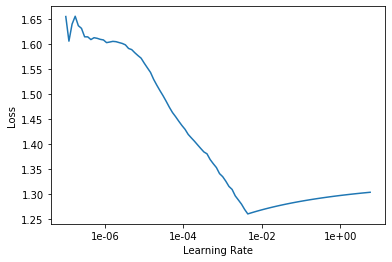

In [10]:
learn.lr_find()
learn.recorder.plot(0,2)

# Training with freezing the encoder

In [11]:
lr = 1e-3
learn.fit_one_cycle(10, max_lr=lr)

# Predictions

In [12]:
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=6,with_loss=True)
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)

mexico-earthquake_00000078_post_disaster_3_0.png
loss: 0.9670395255088806


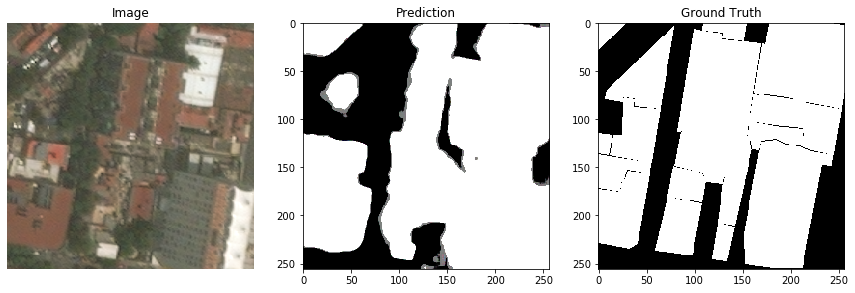

palu-tsunami_00000072_pre_disaster_2_3.png
loss: 0.8778213262557983


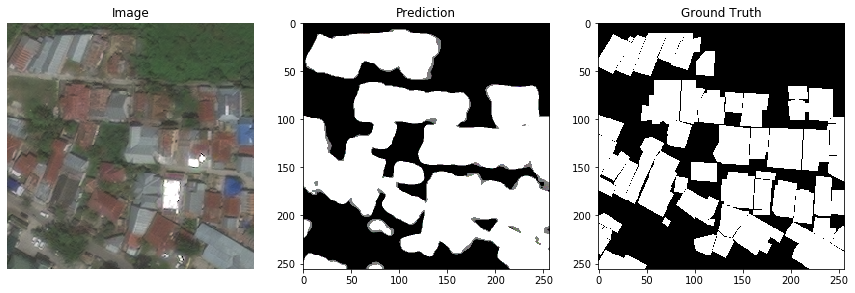

mexico-earthquake_00000173_pre_disaster_2_2.png
loss: 0.876180112361908


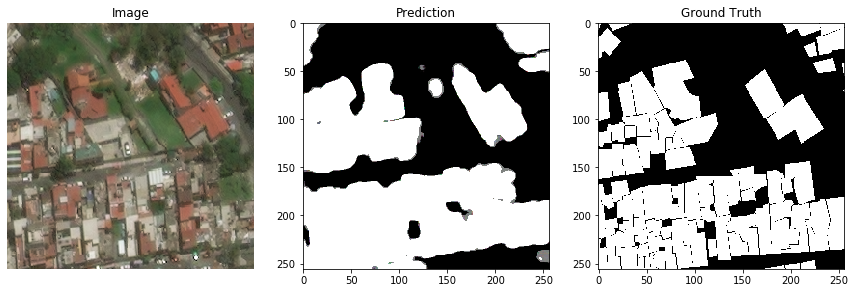

mexico-earthquake_00000068_pre_disaster_2_3.png
loss: 0.8694081902503967


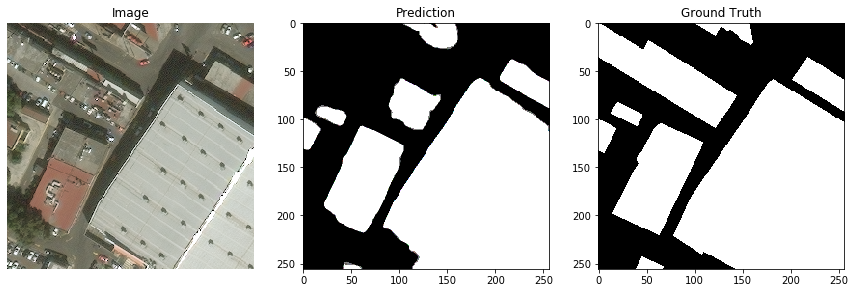

mexico-earthquake_00000004_pre_disaster_1_1.png
loss: 0.8585872650146484


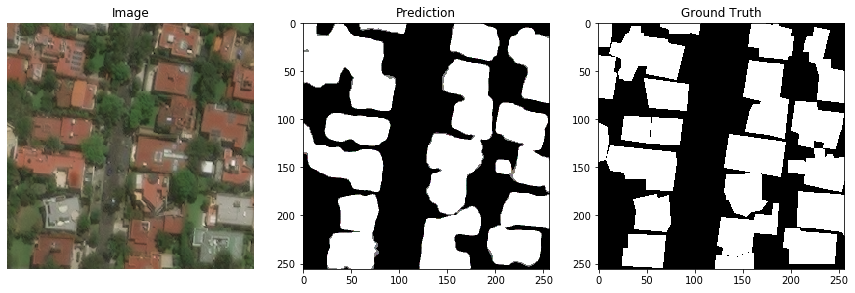

In [13]:
# look at predictions vs actual by channel sorted by highest image-wise loss first

for i in sorted_idx[:5]:

    print(f'{data.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
    
    ax1.set_title('Image')
    data.valid_ds.x[i].show(ax=ax1)
    
    ax2.set_title('Prediction')
    ax2.imshow(image2np(outputs[i].sigmoid()))
    
    ax3.set_title('Ground Truth')
    ax3.imshow(image2np(labels[i])*255)
    plt.show()

# Traning with Unfreezing the encoder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.91E-07


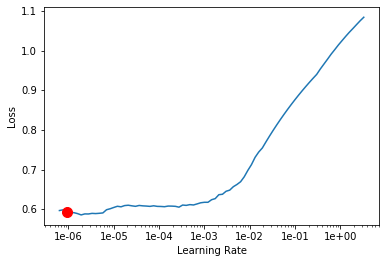

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
learn.fit_one_cycle(20, max_lr=slice(3e-5,3e-4))

# Predictions

In [16]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=6,with_loss=True)
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)

mexico-earthquake_00000078_post_disaster_3_0.png
loss: 0.9768368601799011


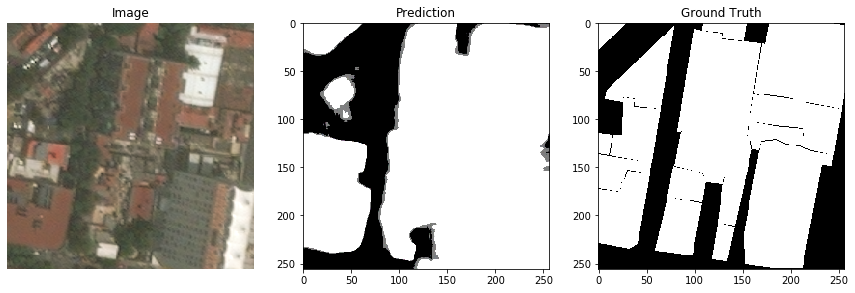

mexico-earthquake_00000068_pre_disaster_2_3.png
loss: 0.8538418412208557


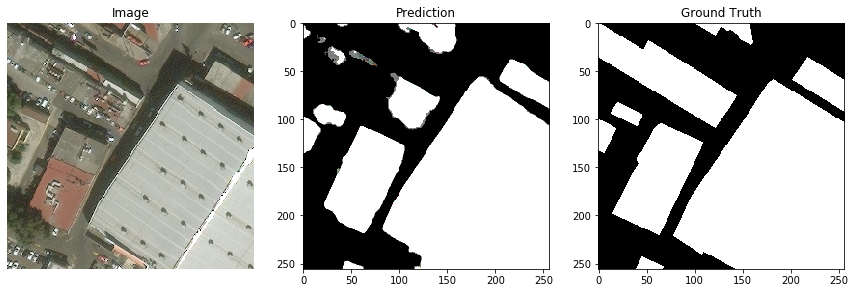

mexico-earthquake_00000173_pre_disaster_2_2.png
loss: 0.8538037538528442


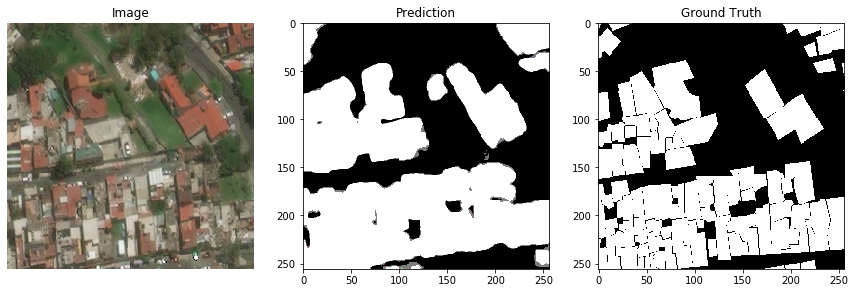

palu-tsunami_00000072_pre_disaster_2_3.png
loss: 0.8437178134918213


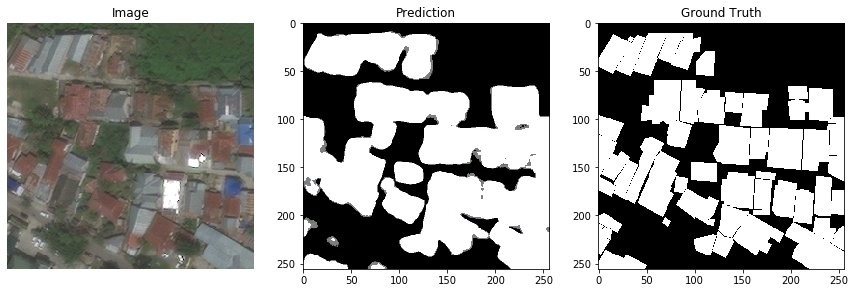

mexico-earthquake_00000004_pre_disaster_1_1.png
loss: 0.8326586484909058


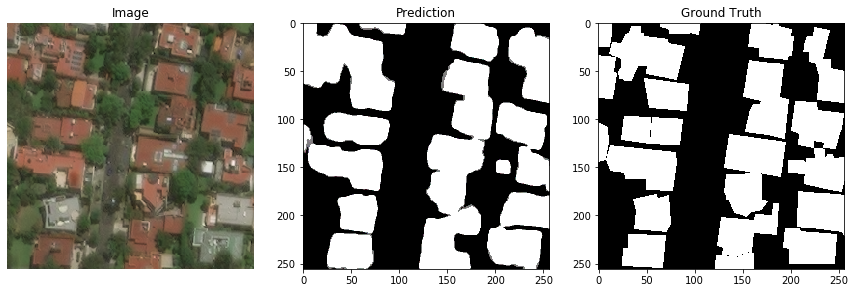

In [17]:
# look at predictions vs actual by channel sorted by highest image-wise loss first

for i in sorted_idx[:5]:

    print(f'{data.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
    
    ax1.set_title('Image')
    data.valid_ds.x[i].show(ax=ax1)
    
    ax2.set_title('Prediction')
    ax2.imshow(image2np(outputs[i].sigmoid()))
    
    ax3.set_title('Ground Truth')
    ax3.imshow(image2np(labels[i])*255)
    plt.show()

In [18]:
learn.export(f'{MODELS_PATH}/segmentation_res34.pkl')

# Scoring

In [19]:
# scoring from ramdonly choosed 100 samples
scoring(100)

  0%|          | 0/100 [00:00<?, ?it/s]

Calculating the score!


100%|██████████| 100/100 [05:01<00:00,  3.01s/it]


Dice:
our model: 0.5112914348906997
baseline model: 0.47105897159248855

IoU:
our model: 0.5106469189438501
baseline model: 0.4705306342972378
